In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

24964


In [2]:
# Required plotting setting
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _single_col_width, _double_col_width, _font_size, _ticklabel_size,_ticklabel_width

from matplotlib import cm
#from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

## Folders

In [3]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920'
# specifically for the first jupyter:
if not os.path.exists(postanalysis_folder):
    print(f"create postanalysis_folder: {postanalysis_folder}")
    os.makedirs(postanalysis_folder)
else:
    print(f"use postanalysis_folder: {postanalysis_folder}")

# figure folder    
dark_mode = False
if dark_mode:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0920_dark')
    plt.style.use('dark_background')
else:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0920')
print(figure_folder)

if not os.path.exists(figure_folder):
    print(f"create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"use figure_folder: {figure_folder}")

use postanalysis_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920
\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920
use figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920


In [4]:
comp_figure_folder = os.path.join(figure_folder, 'AB_compartment')

if not os.path.exists(comp_figure_folder):
    print(f"Create: {comp_figure_folder}")
    os.makedirs(comp_figure_folder)
else:
    print(f"Use: {comp_figure_folder}")

Use: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920\AB_compartment


# 1. Compartment calling from Hi-C

## Load codebook

In [5]:
import pandas as pd
from ImageAnalysis3.structure_tools import distance
# load codebook
codebook = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\merged_codebook.csv')
# partition by chr
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=False)

## process hi-C raw

In [6]:
# function to compress the hi-c count map by binning the previusoly merged bins
def compress_hic_map (hic_count_map, compress_size =1): 
    
    print(f'-- Input count map shape is {hic_count_map.shape}.')
    if len(hic_count_map.shape) !=2 or hic_count_map.shape[0]!=hic_count_map.shape[1]:
        print(f'-- Input count map is invalid.')
        return None
    
    # add empty pseduo bins if the last ctp loci does not have enough hic bins to merge
    if len(hic_count_map)%compress_size !=0:
        print(f'-- Add empty bins to the input map to enable the compression.')
        residual = len(hic_count_map)%compress_size
        add_num = compress_size - residual 
        new_dim = len(hic_count_map)+add_num
        new_hic_count_map = np.zeros([new_dim,new_dim])
        new_hic_count_map[:len(hic_count_map),:len(hic_count_map)]=hic_count_map
        hic_count_map =new_hic_count_map
        
    print(f'-- Summing the input count map over every {compress_size} loci')
    # reshape to split the rows into (splitted_rows, compress_size, cols ) and sum the splitted_row along the compression-axis
    new_row_num = int(hic_count_map.shape[-1]/compress_size)
    sum_count_row = hic_count_map.reshape(new_row_num,compress_size,hic_count_map.shape[-1]).sum(1) #sum along axis 1
    # reshape to split the col into (splitted_rows, compress_size, splitted_cols) and splitted_cols along the compression-axis
    new_col_num = new_row_num
    sum_count_row_col = sum_count_row.reshape(new_row_num,new_col_num,compress_size).sum(2) #sum along axis 2
    #print(sum_count_row_col.shape)
    
    return sum_count_row_col

In [7]:
hic_save_folder = r'W:\HiC_cortex\hic_map_cortex_20kb'

hic_reg_df = pd.read_csv(os.path.join(hic_save_folder, 'filtered_regions.csv'), )


hic_files = [os.path.join(hic_save_folder,_fl) for _fl in os.listdir(hic_save_folder) if 'HiC_20kb_chr_' in _fl]
chr_2_hic_raw = {}
for _fl in hic_files:
    _hic_mat = np.load(_fl)
    _chr = os.path.basename(_fl).split('.npy')[0].split('_')[-1]
    chr_2_hic_raw[_chr] = _hic_mat


In [314]:
sel_chr = '2'
_chr_hic_raw = chr_2_hic_raw[sel_chr]
# df
_chr_reg_df = hic_reg_df.loc[hic_reg_df['chr']==int(sel_chr)]
_chr_reg_starts = _chr_reg_df['start'].values

In [315]:
# merge resolution
merge_bins = 3
merged_hic_map = compress_hic_map(_chr_hic_raw, merge_bins)
merged_gstarts = _chr_reg_starts[::merge_bins]

from scipy.spatial.distance import pdist, squareform
_gdist_map = squareform(pdist(merged_gstarts[:,np.newaxis]))

-- Input count map shape is (9106, 9106).
-- Add empty bins to the input map to enable the compression.
-- Summing the input count map over every 3 loci


In [316]:
gdist_entries = _gdist_map[np.triu_indices(len(_gdist_map),1)]
hic_entries = merged_hic_map[np.triu_indices(len(merged_hic_map),1)]
# collapse along distances
dists = np.unique(gdist_entries)

valid_dists = []
mean_counts = []
zero_fracs = []
zero_frac_th = 0.8 # if more than 90% region have zero count, skip
for _d in dists:
    _cts = hic_entries[np.where(gdist_entries==_d)]
    _zero_fr = np.mean(_cts==0)
    if _zero_fr < zero_frac_th:
        valid_dists.append(_d)
        mean_counts.append(np.mean(_cts)+1)
        zero_fracs.append(_zero_fr)
hic_lr = scipy.stats.linregress(np.log(valid_dists), np.log(mean_counts))
print(hic_lr)
hic_poly = np.polyfit(np.log(valid_dists), np.log(mean_counts) ,deg=7)

LinregressResult(slope=-0.40779279875275126, intercept=7.23018769441905, rvalue=-0.7892072490711203, pvalue=3.239401910351285e-137, stderr=0.01256308527137215, intercept_stderr=0.20904766963445862)


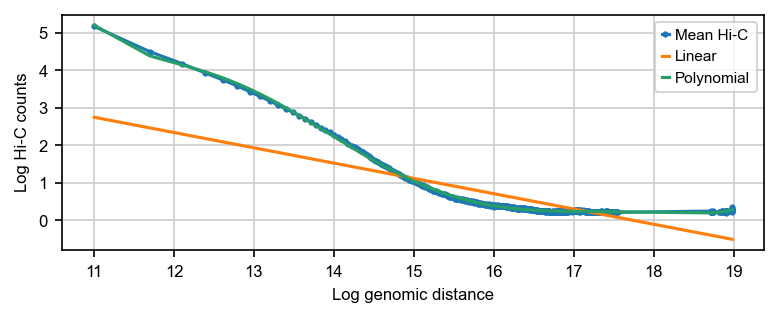

In [317]:
%matplotlib inline
plt.figure(figsize=(6,2), dpi=150)
plt.plot(np.log(valid_dists), np.log(mean_counts), '-o', markersize=2, label='Mean Hi-C')
plt.plot(np.log(valid_dists), (np.log(valid_dists) * hic_lr.slope + hic_lr.intercept), '-', label='Linear')
plt.plot(np.log(valid_dists), np.polyval(hic_poly, np.log(valid_dists)), label='Polynomial')
plt.xlabel("Log genomic distance")
plt.ylabel("Log Hi-C counts")
plt.legend()
plt.show()

In [318]:
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

In [319]:
hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
#hic_gdist_norm[np.arange(len(hic_gdist_norm)),np.arange(len(hic_gdist_norm))] = 1e10
hic_normed_map = merged_hic_map / hic_gdist_norm

from scipy.ndimage import gaussian_filter
from numpy import ma

gaussian_sigma = 1

valid_inds = np.where(np.nansum(hic_normed_map, axis=0) > 0)[0]


hic_conv_normed_map = convolve(hic_normed_map[valid_inds, valid_inds[:,np.newaxis]], 
                               Gaussian2DKernel(x_stddev=gaussian_sigma))
hic_corr_map = np.corrcoef(hic_conv_normed_map)


#valid_inds = np.where(hic_normed_map.sum(0) > 0)[0]

#hic_corr_map = np.corrcoef(gaussian_filter(hic_normed_map[valid_inds, valid_inds[:,np.newaxis]], gaussian_sigma))
#hic_corr_map = ma.corrcoef(ma.masked_invalid(hic_normed_map))

C:\Users\puzheng\AppData\Local\Temp/ipykernel_24964/2984611697.py:1: RuntimeWarning: divide by zero encountered in log
  hic_gdist_norm = np.exp(np.polyval(hic_poly, np.log(_gdist_map)))
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\numpy\lib\polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


<IPython.core.display.Javascript object>


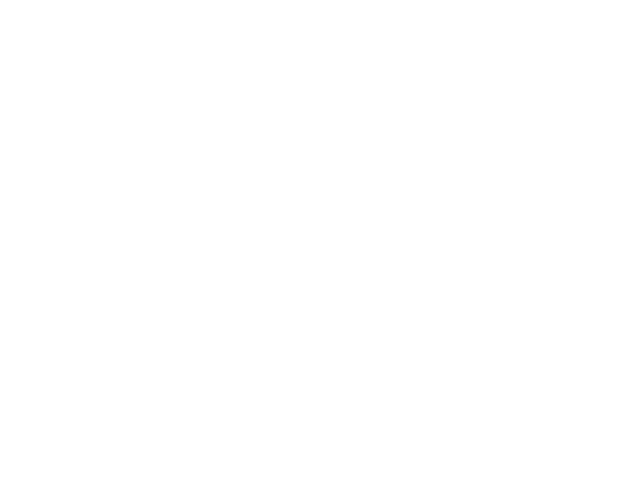

In [321]:
%matplotlib notebook
plt.style.use('default')
plt.figure(dpi=100)
plt.imshow(hic_normed_map, vmin=0, vmax=2, interpolation='nearest', cmap='seismic')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


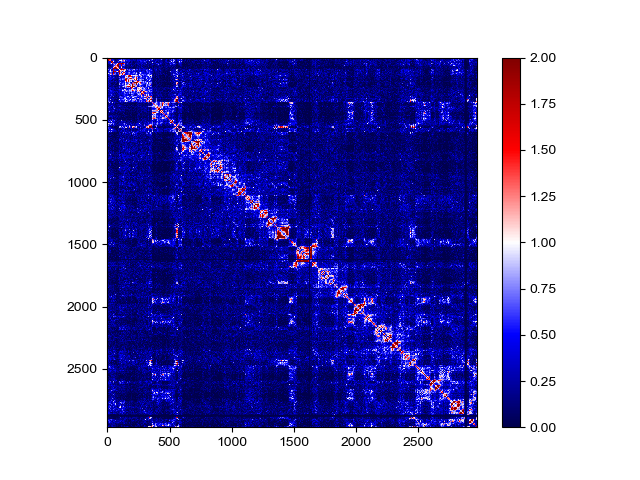

In [322]:
%matplotlib notebook
plt.style.use('default')
plt.figure(dpi=100)
plt.imshow(hic_conv_normed_map, vmin=0, vmax=2, interpolation='nearest', cmap='seismic')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


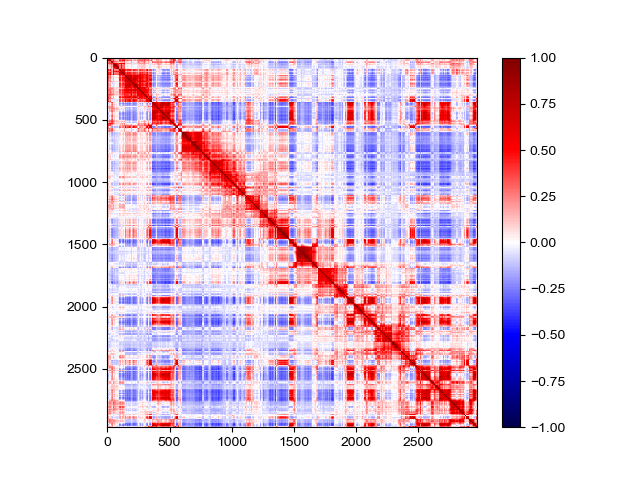

In [323]:
plt.figure(dpi=100)
plt.imshow(hic_corr_map, vmin=-1, vmax=1, cmap='seismic', interpolation='nearest')#norm=LogNorm(0.1,5))
plt.colorbar()
plt.show()

In [324]:
from sklearn.decomposition import PCA
hic_model = PCA(10)
hic_model.fit(hic_corr_map)
hic_pc1 = hic_model.fit_transform(hic_corr_map)[:,0]

In [325]:
hic_pcs = hic_model.fit_transform(hic_corr_map)

<IPython.core.display.Javascript object>


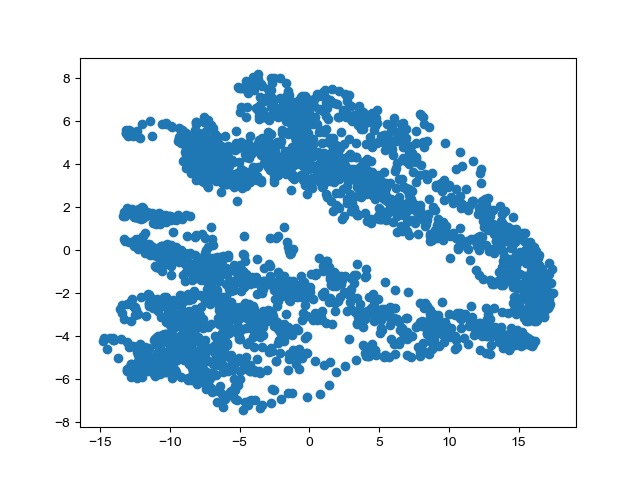

In [326]:
plt.figure()
plt.scatter(hic_pcs[:,0], hic_pcs[:,1])

In [327]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


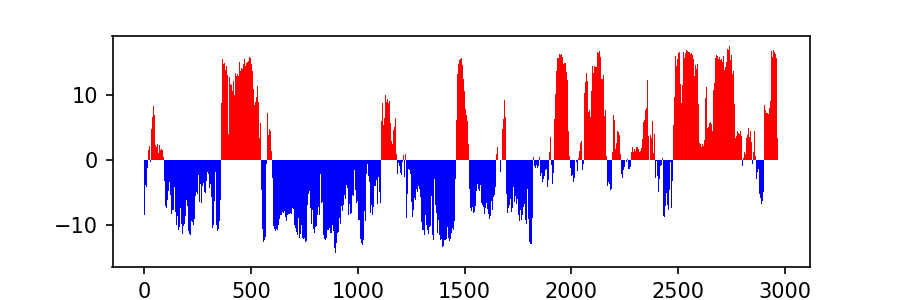

In [328]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2),dpi=150)
hic_ax.bar(np.where(hic_pc1>=0)[0], hic_pc1[np.where(hic_pc1>=0)[0]], #'.', 
            linewidth=1, width=1, color='r', label='A')
hic_ax.bar(np.where(hic_pc1<0)[0], hic_pc1[np.where(hic_pc1<0)[0]], #'.', 
            linewidth=1, width=1, color='b', label='B')
plt.show()

## UMAP

In [329]:
import scanpy as sc
import anndata

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=150, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [330]:
_corr_mat = hic_corr_map

C:\Users\puzheng\AppData\Local\Temp/ipykernel_24964/3732214700.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(_corr_mat)


<IPython.core.display.Javascript object>


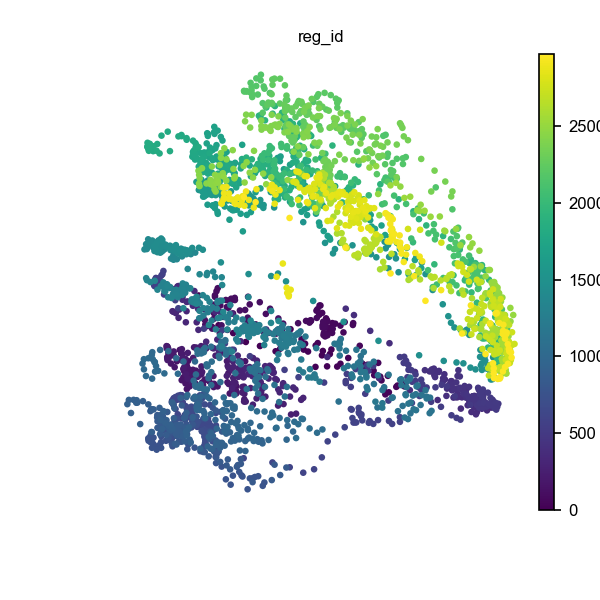

In [331]:

adata = anndata.AnnData(_corr_mat)
adata.obs['reg_id'] = np.arange(0, len(_corr_mat))

# Principal component analysis
sc.tl.pca(adata)
# Plot the PCA results
sc.pl.pca(adata, color='reg_id', s=40)

In [332]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
# Clustering
sc.tl.leiden(adata, resolution=1)
# Embed with UMAP
sc.tl.umap(adata)

Wall time: 4.08 s


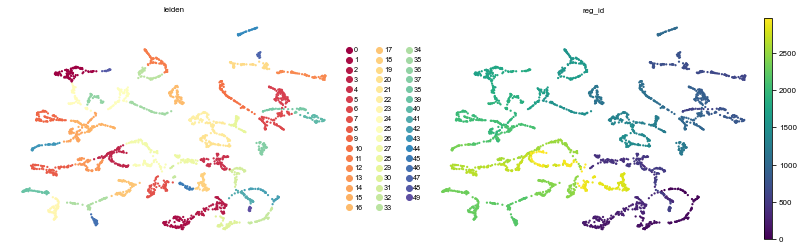

In [333]:
%matplotlib inline
sc.pl.umap(adata, color=['leiden', 'reg_id'], s=20, palette='Spectral',)

(0.0, 3205.0)

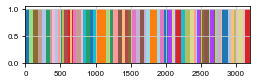

In [306]:
ax, fig = plt.subplots(figsize=(4,1))

for _cls in np.unique(adata.obs['leiden']):
    plt.bar(np.where(adata.obs['leiden'].values==_cls)[0],
             1, width=1 )
    
plt.xlim([0, len(adata)])

In [334]:
# Calculate mean_corr_val
_class_ints = np.sort(np.unique(adata.obs['leiden']).astype(np.int32))
mean_corrs = np.zeros([len(_class_ints), len(_class_ints)])

for _cls_1 in _class_ints:
    _rid_1 = adata.obs.loc[adata.obs['leiden']==str(_cls_1), 'reg_id'].values
    for _cls_2 in _class_ints:
        # self
        if _cls_1 == _cls_2:
            mean_corrs[_cls_1, _cls_2] = 1
            continue
        _rid_2 = adata.obs.loc[adata.obs['leiden']==str(_cls_2), 'reg_id'].values
        #print(_corr_mat[_rid_1[:,np.newaxis], _rid_2].shape, len(_rid_1), len(_rid_2))
        _mean_corr = np.nanmean(_corr_mat[_rid_1[:,np.newaxis], _rid_2])
        mean_corrs[_cls_1, _cls_2] = _mean_corr
        
    

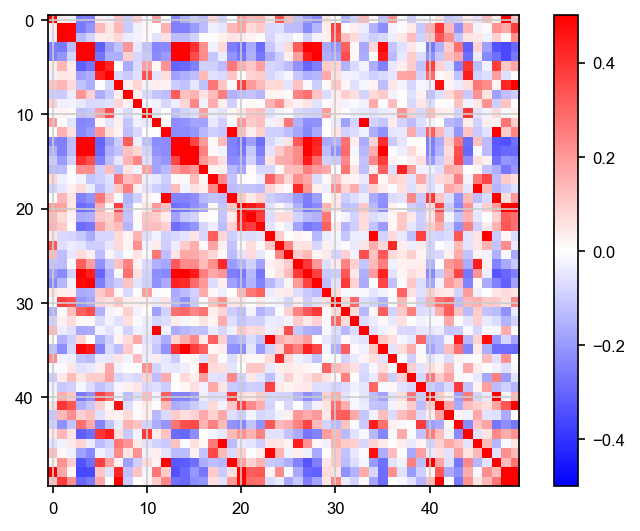

In [335]:
plt.figure(dpi=150)
plt.imshow(mean_corrs, vmin=-0.5, vmax=0.5, cmap='bwr')
plt.colorbar()
plt.show()

In [336]:
from sklearn.decomposition import PCA
mean_corr_model = PCA(10)
mean_corr_model.fit(mean_corrs)
mean_corr_pc1 = mean_corr_model.fit_transform(mean_corrs)[:,0]

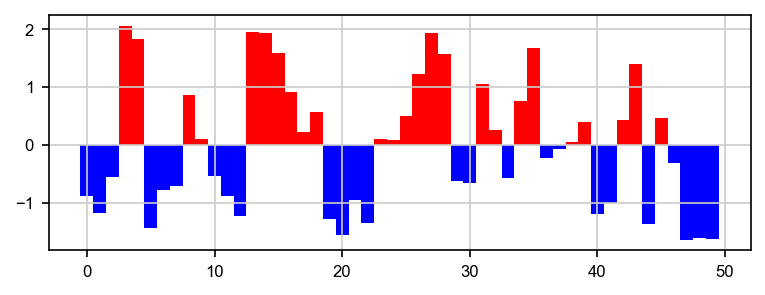

In [337]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2),dpi=150)
hic_ax.bar(np.where(mean_corr_pc1>=0)[0], mean_corr_pc1[np.where(mean_corr_pc1>=0)[0]], #'.', 
            linewidth=1, width=1, color='r', label='A')
hic_ax.bar(np.where(mean_corr_pc1<0)[0], mean_corr_pc1[np.where(mean_corr_pc1<0)[0]], #'.', 
            linewidth=1, width=1, color='b', label='B')
plt.show()

In [338]:
mean_corr_AB_th = 0
A_comp_cls = np.where(mean_corr_pc1 >= mean_corr_AB_th)[0]
B_comp_cls = np.where(mean_corr_pc1 < mean_corr_AB_th)[0]

In [339]:
A_rids, B_rids = [], []
for _cls in _class_ints:
    _rids = adata.obs.loc[adata.obs['leiden']==str(_cls), 'reg_id'].values
    if _cls in A_comp_cls:
        A_rids.append(_rids)
    if _cls in B_comp_cls:
        B_rids.append(_rids)
A_rids = np.sort(np.concatenate(A_rids))
B_rids = np.sort(np.concatenate(B_rids))

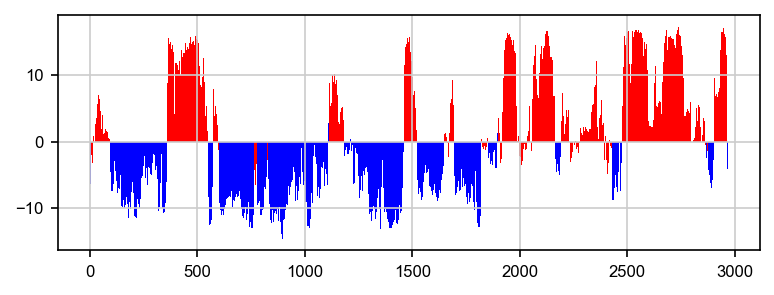

In [340]:
hic_fig, hic_ax = plt.subplots(figsize=(6,2),dpi=150)
hic_ax.bar(A_rids, hic_pc1[A_rids], #'.', 
            linewidth=1, width=1, color='r', label='A')
hic_ax.bar(B_rids, hic_pc1[B_rids], #'.', 
            linewidth=1, width=1, color='b', label='B')
plt.show()

In [ ]:
%matplotlib notebook
plt.style.use('default')

from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

#plt.style.use('dark_background')

fig, ax1 = plt.subplots(figsize=(_single_col_width,_single_col_width), dpi=200)

# create a color map
current_cmap = cm.get_cmap('seismic').copy()
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

#vmin,vmax = 1e-3, 1e-2
hic_corr_norm = 

_pf = ax1.imshow(hic_corr_map, 
                 cmap=current_cmap, 
                 vmin=-1,vmax=1,
                 #norm=LogNorm(vmin=vmin, vmax=vmax, ),
                )

ax1.set_yticks( (_chr_edges[1:] + _chr_edges[:-1])[:-1] / 2 ,)
ax1.set_yticklabels(_chr_names[:-1],)

ax1.hlines(_chr_edges-0.5, 0, len(ensemble_contact_mat), color='yellow', linewidth=0.2)
ax1.vlines(_chr_edges-0.5, 0, len(ensemble_contact_mat), color='yellow', linewidth=0.2)
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([0, len(ensemble_contact_mat)])
ax1.set_ylim([len(ensemble_contact_mat), 0])

ax1.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1)
cbar.ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]

cbar.set_ticks([vmin,vmax])
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Contact Probability', 
               fontsize=_font_size, labelpad=-1, rotation=270)
cbar.ax.minorticks_off()

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(ensemble_AB_dict['A'], ensemble_normedPC1[ensemble_AB_dict['A']]-AB_th, 
           color='r',width=1, bottom=0)
bot_ax.bar(ensemble_AB_dict['B'], ensemble_normedPC1[ensemble_AB_dict['B']]-AB_th, 
           color='b',width=1, bottom=0)

bot_ax.set_xticks((_chr_edges[1:] + _chr_edges[:-1])[:-1]/2,)
bot_ax.set_xticklabels(_chr_names[:-1], rotation=60)
bot_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.tick_params('y', labelsize=_font_size-1, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
bot_ax.set_ylabel('PC1', fontsize=_font_size-1, labelpad=1)
#bot_ax.set_ylim([-10,10])
#bot_ax.set_yticks([0.5,-0.5])
#bot_ax.set_yticklabels(["A","B"])
plt.savefig(os.path.join(comp_figure_folder, f"trans_ensemble_contact_AB.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
# left right chr
ax1.set_xlim([chr_2_indices[left_chr].min(), chr_2_indices[right_chr].max()])
ax1.set_ylim([chr_2_indices[right_chr].max(), chr_2_indices[left_chr].min()])

plt.savefig(os.path.join(comp_figure_folder, f"trans_ensemble_contact_AB_{left_chr}-{right_chr}.pdf"),
            transparent=True, bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()


## match with codebook

# 2. By data itself

In [341]:
# Load class_2_median
# class to median distance dict
class_2_median_filename = os.path.join(postanalysis_folder, 'class_2_medianDict.pkl')

class_2_medianDict = pickle.load(open(class_2_median_filename, 'rb'))

In [342]:
sel_chr = '1'
_chr_codebook = codebook.loc[codebook['chr']==sel_chr]


In [343]:
_region_centers = np.sort([np.mean(np.array(_n.split(sel_chr+':')[1].split('-'), dtype=np.int32)) 
                           for _n in _chr_codebook['name']])

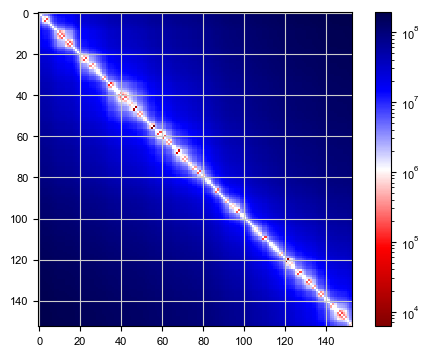

In [345]:
plt.figure(dpi=100)
plt.imshow(gdist_mat, interpolation='nearest', cmap='seismic_r', norm=LogNorm())
plt.colorbar()
plt.show()

In [355]:
median_mat = class_2_medianDict['Gluta'][f'cis_{sel_chr}']

gdist_mat = squareform(pdist(_region_centers[:,np.newaxis]))


gdist_entries = gdist_mat[np.triu_indices(len(gdist_mat),1)]
median_entries = median_mat[np.triu_indices(len(median_mat),1)]
valid_inds = np.isfinite(np.log(gdist_entries)) & np.isfinite(np.log(median_entries))
gdist_entries = gdist_entries[valid_inds]
median_entries = median_entries[valid_inds]

In [357]:
valid_inds.mean()


1.0

In [401]:
median_lr = scipy.stats.linregress(np.log(gdist_entries), np.log(median_entries))
print(median_lr)
median_poly = np.polyfit(np.log(gdist_entries), np.log(median_entries) ,deg=7)

LinregressResult(slope=0.24745609739396873, intercept=-3.5268778433070107, rvalue=0.9333329284212606, pvalue=0.0, stderr=0.000882785975775377, intercept_stderr=0.015557109977683654)


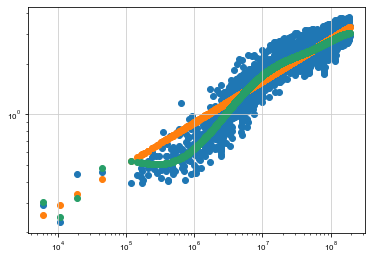

In [402]:
plt.figure()
plt.scatter(gdist_entries, median_entries)
plt.scatter(gdist_entries, np.exp(np.log(gdist_entries) * median_lr.slope + median_lr.intercept ), label='Linear')
plt.scatter(gdist_entries, np.exp(np.polyval(median_poly, np.log(gdist_entries))), label='Polynomial')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [403]:
median_gdist_norm = np.exp(np.polyval(median_poly, np.log(gdist_mat)))
#median_gdist_norm[np.arange(len(median_gdist_norm)),np.arange(len(median_gdist_norm))] = 1e10
median_normed_map = median_mat / median_gdist_norm

from scipy.ndimage import gaussian_filter
from numpy import ma

median_gaussian_sigma = 0.5

valid_inds = np.where(np.nansum(median_normed_map, axis=0) > 0)[0]


median_conv_normed_map = convolve(median_normed_map[valid_inds, valid_inds[:,np.newaxis]], 
                               Gaussian2DKernel(x_stddev=median_gaussian_sigma))
median_corr_map = np.corrcoef(median_conv_normed_map)


C:\Users\puzheng\AppData\Local\Temp/ipykernel_24964/3410025351.py:1: RuntimeWarning: divide by zero encountered in log
  median_gdist_norm = np.exp(np.polyval(median_poly, np.log(gdist_mat)))
E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\numpy\lib\polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


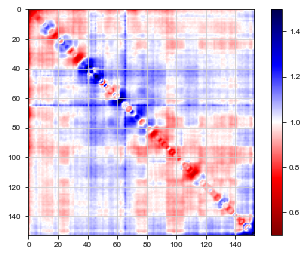

In [406]:
plt.figure()
plt.imshow(median_conv_normed_map, vmin=0.5, vmax=1.5, cmap='seismic_r')
plt.colorbar()
plt.show()

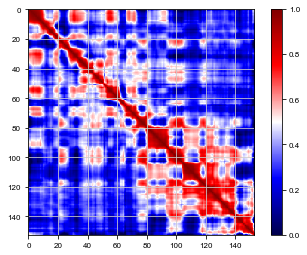

In [407]:
plt.figure()
plt.imshow(median_corr_map, vmin=0, vmax=1, cmap='seismic')
plt.colorbar()
plt.show()

In [395]:
from sklearn.decomposition import PCA
median_model = PCA(10)
median_model.fit(median_corr_map)
median_pc1 = median_model.fit_transform(median_corr_map)[:,0]

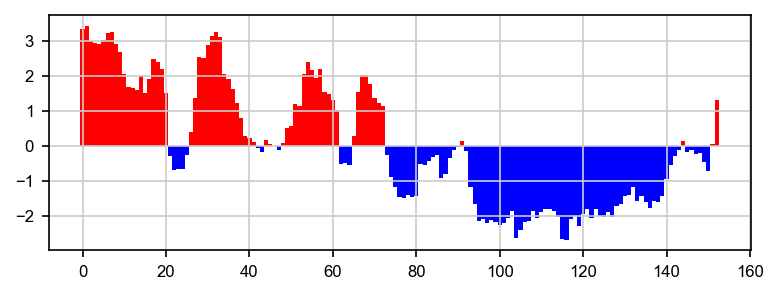

In [396]:
median_fig, median_ax = plt.subplots(figsize=(6,2),dpi=150)
median_ax.bar(np.where(median_pc1>=0)[0], median_pc1[np.where(median_pc1>=0)[0]], #'.', 
            linewidth=1, width=1, color='r', label='A')
median_ax.bar(np.where(median_pc1<0)[0], median_pc1[np.where(median_pc1<0)[0]], #'.', 
            linewidth=1, width=1, color='b', label='B')
plt.show()